# [Multivariate Time Series Forecasting using RNN(LSTM)](https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-rnn-lstm-8d840f3f9aa7)

In [13]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import seaborn as sns
from numpy import sqrt, argsort
from tqdm import tqdm, trange

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

In [14]:
# load the data
df1 = pd.read_csv('DataSetForThesis2.csv')

del df1["Discharge Flow (Nominal m3/hr)"]

# drop the second row
df1 = df1.iloc[1:,:]

# check the missing values
print(f"Missing Values?: {df1.isna().sum().any()}")

# drop the missing values
df1.dropna(inplace=True)

print(f"Missing Values After Dropping?: {df1.isna().sum().any()}")

# check the duplicates
print(f"Number Of Duplicates: {df1.duplicated().sum()}")

print(" ")

# change the data type of the columns to float and date time 
cols=[i for i in df1.columns if i not in ['Date/Time']]
for col in cols:
    df1[col]=pd.to_numeric(df1[col])
    
df1['Date/Time'] = pd.to_datetime(df1['Date/Time'])

df1.head()

Missing Values?: True
Missing Values After Dropping?: False
Number Of Duplicates: 0
 


,Date/Time,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
1,2020-11-07 00:00:00,5.2,26812.4,28.5,7.4,55.2,3.0,4.0,5.0,6.8,6.6,6.60,6.9,7.4,9.727419,10.204235,7.166746,9.235712,8164.449219
2,2020-11-07 00:20:00,5.2,26836.2,28.4,7.4,55.2,3.0,4.0,5.1,7.0,6.7,6.54,6.8,7.5,9.721112,10.209536,7.135931,9.235712,8161.888184
3,2020-11-07 00:40:00,5.2,26856.7,28.3,7.4,55.2,3.1,4.0,5.3,7.3,6.7,6.46,5.7,7.4,9.714805,10.214835,7.105114,9.178102,8162.304688
4,2020-11-07 01:00:00,5.2,26800.2,28.2,7.4,55.2,3.1,4.0,5.1,7.1,6.8,6.49,7.6,7.4,9.708497,10.220136,7.074298,9.116689,8315.385742
5,2020-11-07 01:20:00,5.2,26852.4,28.1,7.4,55.3,3.1,4.2,5.0,6.7,6.7,6.61,7.6,7.5,9.702189,10.225435,7.043482,9.139559,8217.386719


In [15]:
df1.iloc[:,1:]

,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
1,5.2,26812.4,28.5,7.4,55.2,3.0,4.0,5.0,6.8,6.6,6.60,6.9,7.4,9.727419,10.204235,7.166746,9.235712,8164.449219
2,5.2,26836.2,28.4,7.4,55.2,3.0,4.0,5.1,7.0,6.7,6.54,6.8,7.5,9.721112,10.209536,7.135931,9.235712,8161.888184
3,5.2,26856.7,28.3,7.4,55.2,3.1,4.0,5.3,7.3,6.7,6.46,5.7,7.4,9.714805,10.214835,7.105114,9.178102,8162.304688
4,5.2,26800.2,28.2,7.4,55.2,3.1,4.0,5.1,7.1,6.8,6.49,7.6,7.4,9.708497,10.220136,7.074298,9.116689,8315.385742
5,5.2,26852.4,28.1,7.4,55.3,3.1,4.2,5.0,6.7,6.7,6.61,7.6,7.5,9.702189,10.225435,7.043482,9.139559,8217.386719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26277,5.4,26471.1,30.1,7.3,28.4,0.9,0.7,0.7,0.6,0.7,0.65,0.7,0.7,0.906404,0.906404,0.951176,1.009405,0.000000
26278,5.4,26416.4,30.0,7.3,28.2,0.9,0.7,0.7,0.6,0.7,0.65,0.7,0.7,0.906404,0.906404,0.953478,1.009405,0.000000
26279,5.4,26412.1,29.8,7.4,28.0,0.9,0.7,0.7,0.7,0.7,0.65,0.7,0.7,0.906404,0.906404,0.955780,1.009405,0.000000
26280,5.4,26445.5,29.4,7.3,27.9,0.8,0.7,0.7,0.6,0.7,0.65,0.8,0.7,0.937772,0.956760,0.906404,0.989985,0.000000


In [16]:
values=df1.shape[0]
training=0.67 #Use 0.8 for default
what_to_train=values*training

df2=df1.iloc[:,1:19]
df2_date=df1[['Date/Time']]

print("Training Sets")

df2_train=df2.iloc[0:int(what_to_train),0:]
df2_train.iloc[:,0:]=df2_train.iloc[:,0:].astype('float64')

df2_train.head()

Training Sets


,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
1,5.2,26812.4,28.5,7.4,55.2,3.0,4.0,5.0,6.8,6.6,6.60,6.9,7.4,9.727419,10.204235,7.166746,9.235712,8164.449219
2,5.2,26836.2,28.4,7.4,55.2,3.0,4.0,5.1,7.0,6.7,6.54,6.8,7.5,9.721112,10.209536,7.135931,9.235712,8161.888184
3,5.2,26856.7,28.3,7.4,55.2,3.1,4.0,5.3,7.3,6.7,6.46,5.7,7.4,9.714805,10.214835,7.105114,9.178102,8162.304688
4,5.2,26800.2,28.2,7.4,55.2,3.1,4.0,5.1,7.1,6.8,6.49,7.6,7.4,9.708497,10.220136,7.074298,9.116689,8315.385742
5,5.2,26852.4,28.1,7.4,55.3,3.1,4.2,5.0,6.7,6.7,6.61,7.6,7.5,9.702189,10.225435,7.043482,9.139559,8217.386719


In [17]:
# print("Testing Sets")
# df2_test=df2.iloc[int(what_to_train):,1:]

# df2_test["kpi_value"]=df2_test["kpi_value"].astype('float64')
# df2_test["request_count"]=df2_test["request_count"].astype('int64')

# df2_test.reset_index(inplace=True)
# df2_test.head()

print("Training Sets")

df2_test=df2.iloc[int(what_to_train):,0:]
df2_test.iloc[:,0:]=df2_test.iloc[:,0:].astype('float64')
df2_test.reset_index(inplace=True)

df2_test.head()

Training Sets


,index,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
0,17609,5.3,26520.4,43.9,7.3,42.2,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.8,0.924903,0.965977,0.95676,1.009405,2217.723633
1,17610,5.3,26548.2,44.7,7.3,42.3,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.8,0.922801,0.963781,0.95676,1.009405,2218.327148
2,17611,5.3,26510.7,45.2,7.3,42.9,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.920698,0.961586,0.95676,1.009405,2218.930664
3,17612,5.3,26549.8,45.0,7.3,43.7,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.918596,0.959390,0.95676,1.009405,2219.534180
4,17613,5.3,26848.4,44.5,7.3,44.4,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.916493,0.957194,0.95676,1.008579,2220.137695


In [18]:
heading="Compressor speed (RPM)"

print(f"For this case we have {df2_train.shape[0]} Training Sets and {df2_test.shape[0]} Training Sets. and we will be focusing on the {heading}") 

For this case we have 17608 Training Sets and 8673 Training Sets. and we will be focusing on the Compressor speed (RPM)


In [19]:
# heading="Suction Flow (Nominal m3/hr)"
# df2_test[heading]

In [20]:
from sklearn.preprocessing import StandardScaler
sc1=StandardScaler()
df2_train_scaled=sc1.fit_transform(df2_train)
df2_train_scaled
print(df2_train_scaled.shape)

(17608, 18)


In [21]:
df2_train_scaled

array([[-0.96627295,  0.13623514, -0.17417057, ...,  1.68811251,
         1.71461901,  1.91737813],
       [-0.96627295,  0.20971623, -0.1900556 , ...,  1.67682824,
         1.71461901,  1.91660711],
       [-0.96627295,  0.27300877, -0.20594063, ...,  1.66554379,
         1.69849521,  1.9167325 ],
       ...,
       [-0.55682659, -0.74183306,  2.01796338, ..., -0.58694199,
        -0.58772719,  0.12651521],
       [ 1.49040522,  3.88191845,  1.9703083 , ..., -0.5861713 ,
        -0.58772719,  0.1266969 ],
       [-0.55682659, -0.87366679,  2.03384841, ..., -0.58590284,
        -0.58772719,  0.1268786 ]])

In [22]:
sc2=StandardScaler()
df2_train_scaled_y=sc2.fit_transform(df2_train[[heading]])
df2_train_scaled_y
print(df2_train_scaled_y.shape)

(17608, 1)


In [23]:
df2_train_scaled_y

array([[1.91737813],
       [1.91660711],
       [1.9167325 ],
       ...,
       [0.12651521],
       [0.1266969 ],
       [0.1268786 ]])

In [24]:
hops=14 #14 samples
no_records=df2_train_scaled_y.shape[0]
no_cols=4

X_train=[]
y_train=[]
for i in range(hops, no_records):
    X_train.append(df2_train_scaled[i-14:i])
    y_train.append(df2_train_scaled_y[i][0])
X_train, y_train=np.array(X_train), np.array(y_train)

In [25]:
print(X_train.shape)
print(y_train.shape)

(17594, 14, 18)
(17594,)


In [26]:
X_train_shape=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train_shape.shape

(17594, 14, 18)

In [27]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2023-01-04 11:01:03.580886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
model=Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

2023-01-04 11:01:08.210730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 50)            13800     
                                                                 
 dropout (Dropout)           (None, 14, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________


In [29]:
epochs=10
batch_size=32

model.fit(X_train_shape, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
550/550 [==============================] - 8s 10ms/step - loss: 0.0448
Epoch 2/10
550/550 [==============================] - 6s 10ms/step - loss: 0.0185
Epoch 3/10
550/550 [==============================] - 6s 10ms/step - loss: 0.0151
Epoch 4/10
550/550 [==============================] - 5s 10ms/step - loss: 0.0128
Epoch 5/10
550/550 [==============================] - 5s 10ms/step - loss: 0.0115
Epoch 6/10
550/550 [==============================] - 6s 10ms/step - loss: 0.0105
Epoch 7/10
550/550 [==============================] - 6s 10ms/step - loss: 0.0104
Epoch 8/10
550/550 [==============================] - 5s 10ms/step - loss: 0.0107
Epoch 9/10
550/550 [==============================] - 5s 10ms/step - loss: 0.0097
Epoch 10/10
550/550 [==============================] - 5s 10ms/step - loss: 0.0096


In [30]:
df1_train_last=df2_train.iloc[-hops:]
df1_test_full=df2_test.iloc[:,0:]
full_df=pd.concat((df1_train_last, df1_test_full),axis=0)
full_df=full_df.iloc[:,0:18]
print(full_df.shape)
full_df.head()

(8687, 18)


,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
17595,5.3,26554.8,39.3,7.3,35.6,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.954339,0.996719,0.930771,1.009405,2209.274414
17596,5.3,26527.9,40.1,7.3,36.1,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.952236,0.994523,0.932876,1.009405,2209.877930
17597,5.3,26490.1,40.9,7.3,37.6,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.950134,0.992327,0.934981,1.009405,2210.481445
17598,5.3,26480.7,41.7,7.3,39.1,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.948031,0.990131,0.937085,1.009405,2211.084961
17599,5.3,26511.4,41.8,7.3,40.6,0.9,0.7,0.7,0.6,0.7,0.7,0.8,0.7,0.945929,0.987935,0.939190,1.009405,2211.688477


In [31]:
df1_test_full

,index,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
0,17609,5.3,26520.4,43.9,7.3,42.2,0.9,0.7,0.7,0.6,0.7,0.70,0.8,0.8,0.924903,0.965977,0.956760,1.009405,2217.723633
1,17610,5.3,26548.2,44.7,7.3,42.3,0.9,0.7,0.7,0.6,0.7,0.70,0.8,0.8,0.922801,0.963781,0.956760,1.009405,2218.327148
2,17611,5.3,26510.7,45.2,7.3,42.9,0.9,0.7,0.7,0.6,0.7,0.70,0.8,0.7,0.920698,0.961586,0.956760,1.009405,2218.930664
3,17612,5.3,26549.8,45.0,7.3,43.7,0.9,0.7,0.7,0.6,0.7,0.70,0.8,0.7,0.918596,0.959390,0.956760,1.009405,2219.534180
4,17613,5.3,26848.4,44.5,7.3,44.4,0.9,0.7,0.7,0.6,0.7,0.70,0.8,0.7,0.916493,0.957194,0.956760,1.008579,2220.137695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8668,26277,5.4,26471.1,30.1,7.3,28.4,0.9,0.7,0.7,0.6,0.7,0.65,0.7,0.7,0.906404,0.906404,0.951176,1.009405,0.000000
8669,26278,5.4,26416.4,30.0,7.3,28.2,0.9,0.7,0.7,0.6,0.7,0.65,0.7,0.7,0.906404,0.906404,0.953478,1.009405,0.000000
8670,26279,5.4,26412.1,29.8,7.4,28.0,0.9,0.7,0.7,0.7,0.7,0.65,0.7,0.7,0.906404,0.906404,0.955780,1.009405,0.000000
8671,26280,5.4,26445.5,29.4,7.3,27.9,0.8,0.7,0.7,0.6,0.7,0.65,0.8,0.7,0.937772,0.956760,0.906404,0.989985,0.000000


In [32]:
############### Rescaling the test pandas dataframe #############
full_df=sc1.transform(full_df)
full_df.shape

(8687, 18)

In [33]:
############# Reshaping the test pandas dataframe ###############
hops=14
no_records=full_df.shape[0]
no_cols=4
X_train_shape_pred=[]

for i in range(hops,no_records):
    X_train_shape_pred.append(full_df[i-hops:i])
X_train_shape_pred=np.array(X_train_shape_pred)
print(X_train_shape_pred.shape)

(8673, 14, 18)


In [34]:
len(X_train_shape_pred)

8673

In [35]:
ytest=model.predict(X_train_shape_pred)

272/272 [==============================] - 1s 3ms/step


In [36]:
ytest.shape

(8673, 1)

In [37]:
# y_final_pred=sc2.inverse_transform(ytest)
y_final_pred = sc2.inverse_transform(ytest)
y_final_pred

array([[2068.087  ],
       [2097.9175 ],
       [2149.0947 ],
       ...,
       [ 133.42072],
       [ 131.92023],
       [ 127.05682]], dtype=float32)

In [38]:
final_kpi_value_pred=pd.DataFrame(y_final_pred)
final_kpi_value_pred.columns=['final_value_pred']
final_kpi_value_pred

,final_value_pred
0,2068.086914
1,2097.917480
2,2149.094727
3,2199.825684
4,2238.536865
...,...
8668,136.724304
8669,132.285583
8670,133.420715
8671,131.920227


In [39]:
df2_test

,index,Suction Pressure (Bar Gauge without Atmospheric pressure),Suction Flow (Nominal m3/hr),Suction Temperature (oC),Dischrage PreG1e without Atmospheric pressure),Discharge Temperature (oC),Gear Box Output Shaft Drive End (DE) X Vibration (μm),Gear Box Output Shaft Drive End (DE) Y Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Output Shaft Non Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Non Drive End (NDE) X Vibration (μm),Gear Box Input Shaft Drive End (NDE) Y Vibration (μm),Gear Box Input Shaft Drive End (DE) X Vibration (μm),Gear Box Input Shaft Drive End (DE) Y Vibration (μm),Suction Vibration in x,Suction Vibration in y,Discharge Vibration in x,Discharge Vibration in y,Compressor speed (RPM)
0,17609,5.3,26520.4,43.9,7.3,42.2,0.9,0.7,0.7,0.6,0.7,0.70,0.8,0.8,0.924903,0.965977,0.956760,1.009405,2217.723633
1,17610,5.3,26548.2,44.7,7.3,42.3,0.9,0.7,0.7,0.6,0.7,0.70,0.8,0.8,0.922801,0.963781,0.956760,1.009405,2218.327148
2,17611,5.3,26510.7,45.2,7.3,42.9,0.9,0.7,0.7,0.6,0.7,0.70,0.8,0.7,0.920698,0.961586,0.956760,1.009405,2218.930664
3,17612,5.3,26549.8,45.0,7.3,43.7,0.9,0.7,0.7,0.6,0.7,0.70,0.8,0.7,0.918596,0.959390,0.956760,1.009405,2219.534180
4,17613,5.3,26848.4,44.5,7.3,44.4,0.9,0.7,0.7,0.6,0.7,0.70,0.8,0.7,0.916493,0.957194,0.956760,1.008579,2220.137695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8668,26277,5.4,26471.1,30.1,7.3,28.4,0.9,0.7,0.7,0.6,0.7,0.65,0.7,0.7,0.906404,0.906404,0.951176,1.009405,0.000000
8669,26278,5.4,26416.4,30.0,7.3,28.2,0.9,0.7,0.7,0.6,0.7,0.65,0.7,0.7,0.906404,0.906404,0.953478,1.009405,0.000000
8670,26279,5.4,26412.1,29.8,7.4,28.0,0.9,0.7,0.7,0.7,0.7,0.65,0.7,0.7,0.906404,0.906404,0.955780,1.009405,0.000000
8671,26280,5.4,26445.5,29.4,7.3,27.9,0.8,0.7,0.7,0.6,0.7,0.65,0.8,0.7,0.937772,0.956760,0.906404,0.989985,0.000000


In [40]:
fully_final=pd.concat((final_kpi_value_pred, df2_test),axis=1)
fully_final=fully_final[[heading, 'final_value_pred']]
fully_final

,Compressor speed (RPM),final_value_pred
0,2217.723633,2068.086914
1,2218.327148,2097.917480
2,2218.930664,2149.094727
3,2219.534180,2199.825684
4,2220.137695,2238.536865
...,...,...
8668,0.000000,136.724304
8669,0.000000,132.285583
8670,0.000000,133.420715
8671,0.000000,131.920227


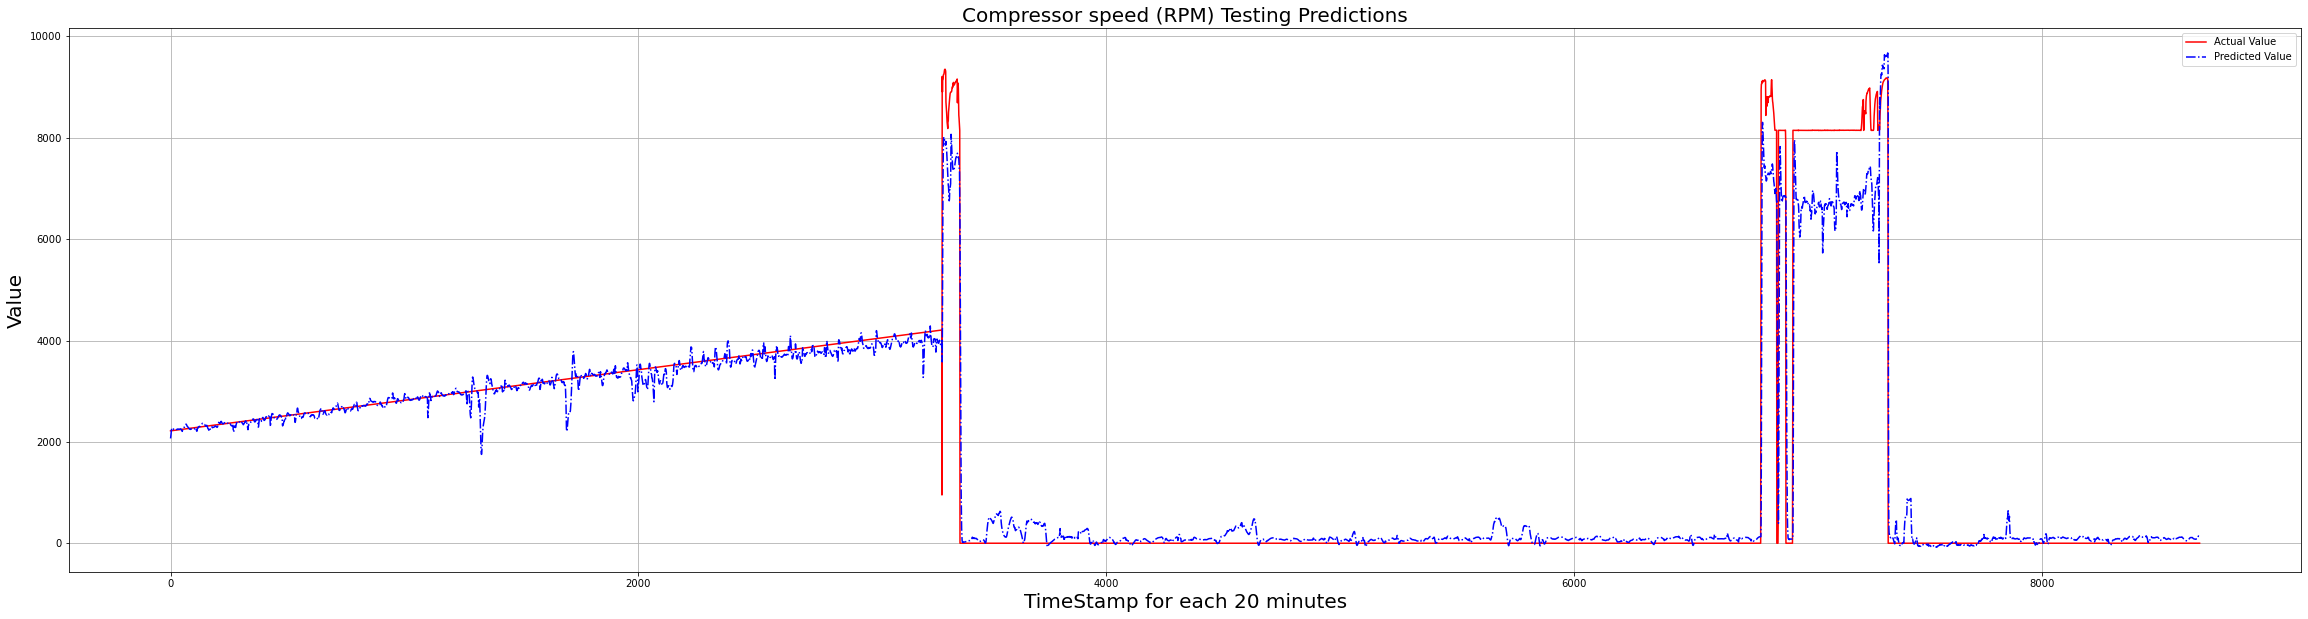

In [41]:
plt.figure(figsize=(40,10))
plt.grid()
plt.title(f"{heading} Testing Predictions", fontsize=20)
plt.xlabel(f"TimeStamp for each 20 minutes", fontsize=20)
plt.ylabel(f"Value", fontsize=20)
plt.plot(fully_final[heading], label='Actual Value', color='red')
plt.plot(fully_final['final_value_pred'], label='Predicted Value', color='blue', linestyle='dashdot')
plt.legend()

**According to the results using Multivariative LSTM modeling, we are able to almost predict the ADNOC values correctly from the Huwaei dataset by taking 14 samples as the inputs to try to predict one output in each iteration**

In [42]:
fully_final[heading].shape

(8673,)

In [43]:
fully_final['final_value_pred'].shape

(8673,)

In [44]:
fully_final[heading][0]-fully_final['final_value_pred'][0]

149.63671893750006

In [45]:
len(fully_final[heading])

8673

In [46]:
def MSE(actual, predicted):
    actual=np.array(actual)
    predicted=np.array(predicted)
    
    SE = (actual - predicted) ** 2
    MSE = np.mean(SE)
    
    return MSE

In [47]:
mean_squared_error=MSE(fully_final[heading], fully_final['final_value_pred'])
mean_squared_error

266233.6718074712

In [48]:
print(f"The Mean Squared Error after calculating the Multivariative LSTM Model for the {heading} is {round(mean_squared_error, 2)}")

The Mean Squared Error after calculating the Multivariative LSTM Model for the Compressor speed (RPM) is 266233.67
